In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

matplotlib.rc("axes", unicode_minus = False)

In [3]:
df1 = pd.read_csv("01 Oxidation.csv")
df2 = pd.read_csv("02 Photo_softbake.csv")
df3 = pd.read_csv("03 Photo_lithograpy.csv")
df4 = pd.read_csv("04 Etching.csv")
df5 = pd.read_csv("05 Ion_Implantation.csv")
df6 = pd.read_csv("06 Inspect.csv")

In [4]:
df = pd.merge(df1, df2, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df3, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df4, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df5, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df6, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])

In [5]:
df.dropna(subset="Thin F2", inplace=True) # 다른 변수들과의 연관성을 찾지못함, 한 행에 여러 열들 결측값 가짐
# pd.set_option('display.max_row', 200)
# pd.set_option('display.max_columns', 200)

In [6]:
df['Ox_Chamber'] = df['Ox_Chamber'].astype('str')
df['photo_soft_Chamber'] = df['photo_soft_Chamber'].astype('str')
df['lithography_Chamber'] = df['lithography_Chamber'].astype('str')
df['Etching_Chamber'] = df['Etching_Chamber'].astype('str')
df['Chamber_Num'] = df['Chamber_Num'].astype('str')
df['path'] = df['Ox_Chamber']+df['photo_soft_Chamber']+df['lithography_Chamber']+df['Etching_Chamber']+df['Chamber_Num']

In [7]:
df.drop(df[df['Oxid_time']<0].index, inplace=True) # 산화시간이 음수
df.drop(df[df['Target']==0].index, inplace=True) # target 값이 0
df.drop(columns = ["Wafer_map","Error_message"],inplace=True) # 웨이퍼맵, 에러메시지

In [8]:
# 시간 데이터 datetime 유형으로 변환
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y')

# 195이상 = 불량(1), 195미만 = 양품(0)
df.loc[df['Target'] >= 195, '불량_195이상'] =1
df.loc[df['Target'] < 195, '불량_195이상'] =0

In [9]:
df.loc[df['Thin F4']<0, 'Thin F4']=df['Thin F4'].median()
df.loc[df['Flux90s']<0, 'Flux90s']=df['Flux90s'].median()
df.loc[df['Flux160s']<0, 'Flux160s']=df['Flux160s'].median()
df.loc[df['Flux160s']<5, 'Flux160s']=df['Flux160s'].median()

In [10]:
df['Thin F1'].fillna(df['Thin F1'].median(), inplace=True)
df['Thin F3'].fillna(df['Thin F3'].median(), inplace=True)
df['Flux60s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux90s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux480s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux840s'].fillna(df['Flux90s'].median(), inplace=True)

In [11]:
# 불필요한 열 제거 
# df.drop(columns=["No_Die", "Lot_Num", "Wafer_Num"], inplace=True)
df.drop(columns=['Vapor','process','Wavelength'])
df.loc[df['Flux840s'] == 8.137500e+16, 'Flux840s'] = df['Flux840s'].mode()[0]
df.loc[df['Flux480s'] == 8.137500e+16, 'Flux480s'] = df['Flux480s'].mode()[0]

In [12]:
df_new = df[['Temp_OXid','ppm','Pressure','type','Oxid_time',
        'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
       'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake',
       'temp_softbake', 'time_softbake', 'UV_type', 'Energy_Exposure',       
        'Temp_Etching', 'Source_Power', 'Flux60s','Flux90s','Flux160s','Flux480s',
       'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp',
       '불량_195이상', 'path']]

In [13]:
# 데이터 구성:Series, DataFrame
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# export_graphviz: 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz

# 다른 방식(.dot -> .png 형식, 출력화면에 맞는)으로 Tree 출력
from subprocess import call
from IPython.display import Image

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

import graphviz

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

df_raw_x = df_new.drop("불량_195이상", axis = 1)
df_raw_y = df_new["불량_195이상"] 

# MinMaxScaler 객체 생성
numeric_columns = df_raw_x.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()

df_raw_x[numeric_columns] = scaler.fit_transform(df_raw_x[numeric_columns])

df_raw_x = pd.get_dummies(df_raw_x, columns=df_raw_x.select_dtypes(include=['object']).columns)
df_raw_x = df_raw_x.astype({column: int for column in df_raw_x.select_dtypes(include=['bool']).columns})

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234, stratify=df_raw_y) 

In [18]:
tree_uncust = DecisionTreeClassifier(random_state=1234 )
tree_uncust.fit(df_train_x, df_train_y)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.909


In [22]:
estimator = DecisionTreeClassifier()
# 구하고자 하는 parameter와 범위
param_grid = {
    "max_depth": [3,5,7,9,11,13],            # 트리의 최대 깊이를 3부터 20까지 시도
    "min_samples_split": [3,5,7,9,11],    # 내부 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [7,9,11,13],       # 리프 노드가 되기 위한 최소 샘플 수
    "criterion": ["gini", "entropy"],           # 노드에서의 분할 기준
    "max_features": [None, "sqrt", "log2"],     # 각 노드에서 분할에 사용할 최대 특성 수
    "splitter": ["best", "random"]              # 각 노드에서 분할할 때 사용할 방법
}
# 정확도가 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=13, min_samples_leaf=9, min_samples_split=9,
                       splitter='random')

best parameter: 
{'criterion': 'gini', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 9, 'splitter': 'random'}

best score: 
0.943


In [23]:
tree_final = DecisionTreeClassifier(max_depth=13, min_samples_leaf=9, min_samples_split=9,
                       splitter='random')
tree_final.fit(df_train_x, df_train_y)

y_pred = tree_final.predict(df_test_x)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

print(classification_report(df_test_y, y_pred, digits=3))

Test Accuracy: 0.931

Test Confusion matrix: 
[[464   8]
 [ 27   9]]
              precision    recall  f1-score   support

         0.0      0.945     0.983     0.964       472
         1.0      0.529     0.250     0.340        36

    accuracy                          0.931       508
   macro avg      0.737     0.617     0.652       508
weighted avg      0.916     0.931     0.919       508



In [22]:
v_feature_names = df_train_x.columns

df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = tree_final.feature_importances_
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
15,Energy_Exposure,0.153
26,type_dry,0.126
14,time_softbake,0.122
18,Flux60s,0.080
12,photoresist_bake,0.072
...,...,...
49,path_13111,0.000
48,path_12333,0.000
47,path_12322,0.000
46,path_12311,0.000


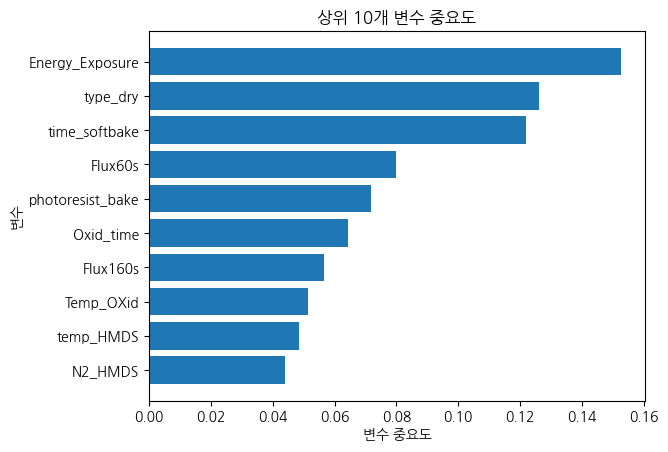

In [23]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
top_10_importance = df_importance.nlargest(10, "Importance")

# 시각화
coordinates = range(len(top_10_importance))
plt.barh(y=coordinates[::-1], width=top_10_importance["Importance"])
plt.yticks(coordinates[::-1], top_10_importance["Feature"], fontsize=10)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.title("상위 10개 변수 중요도")
plt.show()

### SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [25]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_train_x, df_train_y)
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_resampled, y_resampled)

y_pred = tree_clf.predict(df_test_x)
print(classification_report(df_test_y, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       472
         1.0       0.34      0.72      0.46        36

    accuracy                           0.88       508
   macro avg       0.66      0.81      0.70       508
weighted avg       0.93      0.88      0.90       508



In [26]:
estimator = DecisionTreeClassifier()
# 구하고자 하는 parameter와 범위
param_grid = {
    "max_depth": [3,5,7,9,11,13],            # 트리의 최대 깊이를 3부터 20까지 시도
    "min_samples_split": [3,5,7,9,11],    # 내부 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [7,9,11,13],       # 리프 노드가 되기 위한 최소 샘플 수
    "criterion": ["gini", "entropy"],           # 노드에서의 분할 기준
    "max_features": [None, "sqrt", "log2"],     # 각 노드에서 분할에 사용할 최대 특성 수
    "splitter": ["best", "random"]              # 각 노드에서 분할할 때 사용할 방법
}
# 정확도가 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_dt.fit(X_resampled, y_resampled)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=13, min_samples_leaf=7, min_samples_split=5)

best parameter: 
{'criterion': 'gini', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 5, 'splitter': 'best'}

best score: 
0.909


In [27]:
tree_clf = DecisionTreeClassifier(max_depth=13, min_samples_leaf=7, min_samples_split=5)
tree_clf.fit(X_resampled, y_resampled)

y_pred = tree_clf.predict(df_test_x)
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred))

Confusion matrix: 
[[412  60]
 [  9  27]]
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92       472
         1.0       0.31      0.75      0.44        36

    accuracy                           0.86       508
   macro avg       0.64      0.81      0.68       508
weighted avg       0.93      0.86      0.89       508

